In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import json
import pickle
import tqdm
import time
import datetime


from sklearn import linear_model
from sklearn.utils.testing import ignore_warnings

np.set_printoptions(precision=4, suppress=True)

from collections import Counter

import scipy.stats as sts
from sklearn.linear_model import LogisticRegression, LinearRegression

In [3]:
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

----

### Задание

**Background**: в спортивном “Что? Где? Когда?” соревнующиеся команды отвечают на одни и те же вопросы. После минуты обсуждения команды записывают и сдают свои ответы на карточках; побеждает тот, кто ответил на большее число вопросов. Турнир обычно состоит из нескольких десятков вопросов (обычно 36 или 45, иногда 60, больше редко). Часто бывают синхронные турниры, когда на одни и те же вопросы отвечают команды на сотнях игровых площадок по всему миру, т.е. в одном турнире могут играть сотни, а то и тысячи команд. Соответственно, нам нужно:
- построить рейтинг-лист, который способен нетривиально предсказывать результаты будущих турниров;
- при этом, поскольку ЧГК — это хобби, и контрактов тут никаких нет, игроки постоянно переходят из команды в команду, сильный игрок может на один турнир сесть поиграть за другую команду и т.д.; поэтому единицей рейтинг-листа должна быть не команда, а отдельный игрок;


### Структура решения

I часть, в которой генерятся фичи для задачи предсказания вероятностности ответить на вопрос

II часть, в которой я понял, что на тесте будут ровно те же игроки, что и на трейне, а значит можно переобучаться сколько душе угодно

III часть, где предсказываются результаты турниров 2020 года с известными составами, но неизвестными вопросами

IV часть, где вводится ЕМ-алгоритм для учета влияния скрытой переменной "сила команды"

V часть, с рейтинг-листом турниров по сложности вопросов.

----

### I часть, в которой генерятся фичи и решается задача предсказания вероятностности ответить на вопрос

Читаем данные и генерируем фичи: 
- характеристики игрока
  - сколько турниров cыграл игрок
  - средний процент верных ответов 
  - средний процент верных ответов по маскам из questionQty
  - relative_team_position - относительная позициия в турнире (относительная т.к. есть турниры на 20 команд и на 1000+ команд)

In [4]:
%%time
tournaments = pickle.load(open('./data/tournaments.pkl', 'rb'))
results = pickle.load(open('./data/results.pkl', 'rb'))
players = pickle.load(open('./data/players.pkl', 'rb'))

CPU times: user 13.9 s, sys: 2.8 s, total: 16.7 s
Wall time: 16.8 s


In [4]:
[ (k, v['name']) for k,v in tournaments.items() if v['dateStart'][:4] == '2019' ][:5]

[(4772, 'Синхрон северных стран. Зимний выпуск'),
 (4973, 'Балтийский Берег. 3 игра'),
 (4974, 'Балтийский Берег. 4 игра'),
 (4975, 'Балтийский Берег. 5 игра'),
 (4986, 'ОВСЧ. 6 этап')]

In [5]:
len([ (k, v['name']) for k,v in tournaments.items() if v['dateStart'][:4] == '2017' ]), \
len([ (k, v['name']) for k,v in tournaments.items() if v['dateStart'][:4] == '2018' ]), \
len([ (k, v['name']) for k,v in tournaments.items() if v['dateStart'][:4] == '2019' ]), \
len([ (k, v['name']) for k,v in tournaments.items() if v['dateStart'][:4] == '2020' ]),

(533, 622, 687, 418)

In [6]:
tournaments[5465]

{'dateEnd': '2019-05-19T18:00:00+03:00',
 'dateStart': '2019-05-18T12:00:00+03:00',
 'id': 5465,
 'name': 'Чемпионат России',
 'orgcommittee': [{'id': 31038,
   'name': 'Владимир',
   'patronymic': 'Владимирович',
   'surname': 'Сушков'},
  {'id': 26469,
   'name': 'Алексей',
   'patronymic': 'Владимирович',
   'surname': 'Рабин'},
  {'id': 25882,
   'name': 'Максим',
   'patronymic': 'Оскарович',
   'surname': 'Поташев'},
  {'id': 144,
   'name': 'Сергей',
   'patronymic': 'Леонидович',
   'surname': 'Абрамов'}],
 'questionQty': {'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15},
 'season': '/seasons/52',
 'synchData': None,
 'type': {'id': 2, 'name': 'Обычный'}}

In [7]:
results[5465][0]['mask'], [p['player']['id'] for p in results[5465][0]['teamMembers']]

('010111101111010110001000111101011010111011000111111111110011110100001010101111111111011110',
 [28751, 30152, 30270, 27822, 27403, 4270])

In [8]:
# for team in results[5465]:
#     summ = sum([int(s) for s in team['mask']])
#     print(team['mask'], [p['player']['id'] for p in team['teamMembers']], summ)

----

In [276]:
%%time
rows = []
for game_id in results:

    if tournaments[game_id]['dateStart'][:4] not in ['2019']:
        continue

    try:
        for team in results[game_id]:
            team_name = team['team']['name']
            position = team['position']
            team_id = team['team']['id']
            player_ids = sorted([p['player']['id'] for p in team['teamMembers']])
            team_mask = team['mask']
            tournaments_type = tournaments[game_id]['type']['name']
            tournaments_questionQty = tournaments[game_id]['questionQty']
            date_start = tournaments[game_id]['dateStart'][:10]
            
            rows.append((game_id, date_start, team_id, player_ids, team_mask, position, tournaments_type, tournaments_questionQty))
            
    except Exception as e:
        #print(game_id, e)
        continue

CPU times: user 3.63 s, sys: 134 ms, total: 3.77 s
Wall time: 3.8 s


In [277]:
df = pd.DataFrame(rows)

In [278]:
df.shape

(86638, 8)

In [279]:
df.head(3)

,0,1,2,3,4,5,6,7
0,4772,2019-01-05,45556,"[6212, 15456, 18036, 18332, 22799, 26089]",111111111011111110111111111100010010,1.0,Синхрон,"{'1': 12, '2': 12, '3': 12}"
1,4772,2019-01-05,1030,"[1584, 1585, 10998, 16206, 40840]",111111111011110100101111011001011010,5.5,Синхрон,"{'1': 12, '2': 12, '3': 12}"
2,4772,2019-01-05,4252,"[10187, 18168, 21060, 23513, 31332, 35850]",111111111011110101101111001011110000,5.5,Синхрон,"{'1': 12, '2': 12, '3': 12}"


In [280]:
df.columns = ['game_id', 'date_start', 'team_id', 'team', 'tmask', 'team_position', 'type', 'questionQty']

In [281]:
df.head(3)

,game_id,date_start,team_id,team,tmask,team_position,type,questionQty
0,4772,2019-01-05,45556,"[6212, 15456, 18036, 18332, 22799, 26089]",111111111011111110111111111100010010,1.0,Синхрон,"{'1': 12, '2': 12, '3': 12}"
1,4772,2019-01-05,1030,"[1584, 1585, 10998, 16206, 40840]",111111111011110100101111011001011010,5.5,Синхрон,"{'1': 12, '2': 12, '3': 12}"
2,4772,2019-01-05,4252,"[10187, 18168, 21060, 23513, 31332, 35850]",111111111011110101101111001011110000,5.5,Синхрон,"{'1': 12, '2': 12, '3': 12}"


#### Немного чистки: 

заменить '?' на 0, 'X' на ''

Команды, у которых длина маски меньше положенного - заполняем знаком 'N' ('no data')

то есть неполную маску 101101010111001 мы превращаем в 101101010111001NNNNNNNNNNNNNNNNNNNNN

In [282]:
%%time
df = df[df.team.apply(len) != 0]
df = df[df.tmask.notnull()]

df.date_start = pd.to_datetime(df.date_start)

df.tmask = df.tmask.str.replace('?', '0')    # заменяем на ноль 
df.tmask = df.tmask.str.replace('X', '')     # 'X' - удаляем, т.к. у всех других команд на этом месте всегда тоже 'X'

df['tmask_sum'] = df.tmask.apply(lambda x: sum([int(s) for s in x ]))

# будем использовать как фичу
dd = {'Синхрон': '1', 'Асинхрон': '2', 'Обычный': '3', 'Общий зачёт': '3', 'Строго синхронный': '1'}
df.type = df.type.map(dd).fillna('1').astype(int)

# # 16 турниров, где у команд неодинаковая длина маски
# # турниры: [5462, 5553, 5554, 5703, 5705, 5760, 5864, 6026, 6085, 6090, 6249, 6254, 6255, 6265, 6307, 6308]
df['tmask_len'] = df.tmask.apply(len) 
zz = df.groupby('game_id').tmask_len.nunique().loc[lambda x: x != 1]
# можно удалить, но тогда теряем 10% датасета!
# df = df[~df.game_id.isin(zz.index)]
# поэтому мы будем заполнять символом N - No data
# то есть неполную маску 101101010111001 мы превращаем в 101101010111001NNNNNNNNNNNNNNNNNNNNN
df['tmask_max_len'] = df.game_id.map( df.groupby('game_id').tmask_len.max() )
condition = df.game_id.isin(zz.index)
df.loc[condition, 'tmask'] = df[condition].tmask.str.pad(width=999, side='right', fillchar='N')
df.loc[condition, 'tmask'] = df[condition].apply(lambda x: x.tmask[:x.tmask_max_len], axis=1)

CPU times: user 1.61 s, sys: 34 ms, total: 1.64 s
Wall time: 1.66 s


In [283]:
df.head()

,game_id,date_start,team_id,team,tmask,team_position,type,questionQty,tmask_sum,tmask_len,tmask_max_len
0,4772,2019-01-05,45556,"[6212, 15456, 18036, 18332, 22799, 26089]",111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36
1,4772,2019-01-05,1030,"[1584, 1585, 10998, 16206, 40840]",111111111011110100101111011001011010,5.5,1,"{'1': 12, '2': 12, '3': 12}",25,36,36
2,4772,2019-01-05,4252,"[10187, 18168, 21060, 23513, 31332, 35850]",111111111011110101101111001011110000,5.5,1,"{'1': 12, '2': 12, '3': 12}",25,36,36
3,4772,2019-01-05,5444,"[15381, 27375, 28939, 36742, 54289]",101111101111111110001101011001111010,5.5,1,"{'1': 12, '2': 12, '3': 12}",25,36,36
4,4772,2019-01-05,40931,"[12400, 17720, 26988, 28689, 30597, 69476]",111111101011111101000111001001111110,5.5,1,"{'1': 12, '2': 12, '3': 12}",25,36,36


перейдем от представления турнир-команда к представлению турнир-игрок

In [284]:
%%time

# df2 = df[['game_id', 'date_start', 'team_id', 'team', 'tmask', 'team_position']].copy()
df2 = df.copy()

df2 = df2.explode('team')

df2 = df2.rename(columns={'team': 'player_id'})

df2['tmask_list'] = df2.tmask.apply(lambda x: [(question_id, y) for question_id, y in enumerate(x)])
# df2 = df2.drop(['tmask'], axis=1)

CPU times: user 4.65 s, sys: 707 ms, total: 5.36 s
Wall time: 5.39 s


In [285]:
df2.head()

,game_id,date_start,team_id,player_id,tmask,team_position,type,questionQty,tmask_sum,tmask_len,tmask_max_len,tmask_list
0,4772,2019-01-05,45556,6212,111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
0,4772,2019-01-05,45556,15456,111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
0,4772,2019-01-05,45556,18036,111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
0,4772,2019-01-05,45556,18332,111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."
0,4772,2019-01-05,45556,22799,111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1..."


In [286]:
def tmask_1_rate(x):
    """ процент единичек """
    try: 
        mask_to_int = [int(i) for i in x if i != 'N']
        sum_ones = sum(mask_to_int)
        len_mask = len(mask_to_int)
        return sum_ones / len_mask
    except: 
        return np.NaN

In [287]:
def tmask_N_rate(x):
    """ процент где вопрос это 'N' """
    mask_to_int = sum([1 for i in x if i == 'N'])
    return mask_to_int / len(x)

In [288]:
%%time
df2['questions_hit_rate'] = df2.tmask.apply(tmask_1_rate)
df2['questions_N_rate'] = df2.tmask.apply(tmask_N_rate)

CPU times: user 7.95 s, sys: 205 ms, total: 8.16 s
Wall time: 8.2 s


In [289]:
df2['relative_team_position'] = df2.team_position / df2.game_id.map( df2.groupby('game_id').team_id.nunique() )

### questionQty

Вопросы разделены на несколько стадий, обычно 12 + 12 + 12 , но иногда бывает 15+15+15 или 36 + 36 + 36 + 36 + 36 + 36 и др.

Посчитаем по каждой стадии процент верных ответов т.к. есть гипотеза что первая стадия чуть проще чем последняя.

In [24]:
df2.questionQty.astype(str).value_counts()[:20]

{'1': 12, '2': 12, '3': 12}                                        305758
{'1': 15, '2': 15, '3': 15}                                         27348
{'1': 36, '2': 36, '3': 36, '4': 36, '5': 36, '6': 36}              17545
{'1': 12, '2': 12, '3': 12, '4': 12}                                16358
{'1': 36, '2': 36, '3': 36, '4': 36}                                11399
{'1': 13, '2': 13, '3': 13}                                         10524
{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15, '6': 15}               6638
{'1': 36, '2': 45, '3': 45, '4': 36, '5': 36, '6': 36}               6086
{'1': 15, '2': 15, '3': 15, '4': 15, '5': 15}                        5646
{'1': 18, '2': 18}                                                   4818
{'1': 36, '2': 36, '3': 36, '4': 36, '5': 36, '6': 36, '7': 36}      4753
{'1': 12, '2': 12, '3': 12, '4': 12, '5': 12, '6': 12}               4331
{'1': 15, '2': 15, '3': 15, '4': 15}                                 3695
{'1': 14, '2': 14, '3': 14}           

In [25]:
condition = df2.questionQty.apply(len) > 0
df2.loc[condition, 'tmask_p1'] = df2.loc[condition, 'tmask'].apply(lambda x: x[: len(x) // 3])
df2.loc[condition, 'tmask_p2'] = df2.loc[condition, 'tmask'].apply(lambda x: x[len(x) // 3 : 2 * len(x) // 3])
df2.loc[condition, 'tmask_p3'] = df2.loc[condition, 'tmask'].apply(lambda x: x[2 * len(x) // 3 :])

condition = df2.questionQty.apply(len) % 2
df2.loc[condition, 'tmask_p1'] = df2.loc[condition, 'tmask'].apply(lambda x: x[: len(x) //2 ])
df2.loc[condition, 'tmask_p3'] = df2.loc[condition, 'tmask'].apply(lambda x: x[len(x) // 2 :])

condition = df2.questionQty.apply(len) % 4 == 0
df2.loc[condition, 'tmask_p1'] = df2.loc[condition, 'tmask'].apply(lambda x: x[: len(x) // 4])
df2.loc[condition, 'tmask_p2'] = df2.loc[condition, 'tmask'].apply(lambda x: x[len(x) // 4 : 2 * len(x) // 4])
df2.loc[condition, 'tmask_p2'] = df2.loc[condition, 'tmask'].apply(lambda x: x[len(x) // 4 : 3 * len(x) // 4])
df2.loc[condition, 'tmask_p3'] = df2.loc[condition, 'tmask'].apply(lambda x: x[3 * len(x) // 4 :])

condition = df2.questionQty.apply(len) % 3 == 0
df2.loc[condition, 'tmask_p1'] = df2.loc[condition, 'tmask'].apply(lambda x: x[: len(x) // 3])
df2.loc[condition, 'tmask_p2'] = df2.loc[condition, 'tmask'].apply(lambda x: x[len(x) // 3 : 2 * len(x) // 3])
df2.loc[condition, 'tmask_p3'] = df2.loc[condition, 'tmask'].apply(lambda x: x[2 * len(x) // 3 :])

condition = df2.questionQty.apply(len) % 5 == 0
df2.loc[condition, 'tmask_p1'] = df2.loc[condition, 'tmask'].apply(lambda x: x[: len(x) // 5 ])
df2.loc[condition, 'tmask_p1'] = df2.loc[condition, 'tmask'].apply(lambda x: x[len(x) // 5 : 2 * len(x) // 5 ])
df2.loc[condition, 'tmask_p2'] = df2.loc[condition, 'tmask'].apply(lambda x: x[2 * len(x) // 5 : 3 * len(x) // 5 ])
df2.loc[condition, 'tmask_p3'] = df2.loc[condition, 'tmask'].apply(lambda x: x[3 * len(x) // 5 : 4 * len(x) // 5 ])
df2.loc[condition, 'tmask_p3'] = df2.loc[condition, 'tmask'].apply(lambda x: x[4 * len(x) // 5  :])

In [26]:
df2['tmask_p1_hit_rate'] = df2.tmask_p1.apply(tmask_1_rate)
df2['tmask_p2_hit_rate'] = df2.tmask_p2.apply(tmask_1_rate)
df2['tmask_p3_hit_rate'] = df2.tmask_p3.apply(tmask_1_rate)

In [27]:
df2['tmask_len'] = df2.tmask.apply(len)

### Ключевой момент: джойн сам с собой + условие на дату, чтобы не заглядывать в будущее. То есть для каждой игры считаем статистики только по прошлым турнирам

In [28]:
%%time
dff = pd.merge(df2[['date_start', 'player_id', 'game_id']], df2, on='player_id')
dff = dff[dff.date_start_y < dff.date_start_x]

CPU times: user 11.3 s, sys: 3.74 s, total: 15 s
Wall time: 15.2 s


In [29]:
dff.head(5)

,date_start_x,player_id,game_id_x,game_id_y,date_start_y,team_id,tmask,team_position,type,questionQty,tmask_sum,tmask_len,tmask_max_len,tmask_list,questions_hit_rate,questions_N_rate,relative_team_position,tmask_p1,tmask_p2,tmask_p3,tmask_p1_hit_rate,tmask_p2_hit_rate,tmask_p3_hit_rate
8,2019-01-05,6212,4772,5083,2019-01-04,68894,001111011011100010101110101110001001,2.0,1,"{'1': 12, '2': 12, '3': 12}",20,36,36,"[(0, 0), (1, 0), (2, 1), (3, 1), (4, 1), (5, 1...",0.555556,0.0,0.026316,001111011011,100010101110,101110001001,0.666667,0.500000,0.500000
82,2019-01-25,6212,4973,4772,2019-01-05,45556,111111111011111110111111111100010010,1.0,1,"{'1': 12, '2': 12, '3': 12}",28,36,36,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...",0.777778,0.0,0.004329,111111111011,111110111111,111100010010,0.916667,0.916667,0.500000
88,2019-01-25,6212,4973,5055,2019-01-11,59865,110111111111111111010100111010110100101,5.0,1,"{'1': 13, '2': 13, '3': 13}",28,39,39,"[(0, 1), (1, 1), (2, 0), (3, 1), (4, 1), (5, 1...",0.717949,0.0,0.037037,1101111111111,1111101010011,1010110100101,0.923077,0.692308,0.538462
90,2019-01-25,6212,4973,5083,2019-01-04,68894,001111011011100010101110101110001001,2.0,1,"{'1': 12, '2': 12, '3': 12}",20,36,36,"[(0, 0), (1, 0), (2, 1), (3, 1), (4, 1), (5, 1...",0.555556,0.0,0.026316,001111011011,100010101110,101110001001,0.666667,0.500000,0.500000
91,2019-01-25,6212,4973,5097,2019-01-11,59865,111111111011111101111111110111111,5.5,1,"{'1': 12, '2': 12, '3': 12}",30,33,33,"[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...",0.909091,0.0,0.015850,11111111101,11111011111,11110111111,0.909091,0.909091,0.909091


Считаем характеристики силы игрока 

- сколько турниров отыграл
- средний процент верных ответов
- какие занимал позиции в рейтинге: средняя, самая лучшая, самая худшая, дисперсия (aka постоянство)
- процент ответов по разным ступеням/стадиям вопросов (questionQty: part1 - part2 - part3)

In [30]:
%%time
player_feats = \
    dff.groupby(['player_id', 'date_start_x', 'game_id_x'])\
       .agg(
            {'game_id_y': ['count']
            , 'team_position': ['max', 'min', 'mean', 'std']
            , 'relative_team_position': ['max', 'min', 'mean', 'std']
            , 'questions_hit_rate': ['min', 'max', 'mean', 'std']
            , 'questions_N_rate': ['min', 'max', 'mean', 'std']
            , 'tmask_p1_hit_rate': ['min', 'max', 'mean', 'std']
            , 'tmask_p2_hit_rate': ['min', 'max', 'mean', 'std']
            , 'tmask_p3_hit_rate': ['min', 'max', 'mean', 'std']
           })

CPU times: user 4.81 s, sys: 318 ms, total: 5.13 s
Wall time: 5.18 s


In [31]:
player_feats.columns = [i + '_' + j for i,j in player_feats.columns]

In [32]:
player_feats = player_feats.reset_index()

In [33]:
player_feats = player_feats.drop_duplicates(['player_id', 'date_start_x'])
player_feats = player_feats.drop('game_id_x', axis=1)

In [34]:
player_feats.head(11)

,player_id,date_start_x,game_id_y_count,team_position_max,team_position_min,team_position_mean,team_position_std,relative_team_position_max,relative_team_position_min,relative_team_position_mean,relative_team_position_std,questions_hit_rate_min,questions_hit_rate_max,questions_hit_rate_mean,questions_hit_rate_std,questions_N_rate_min,questions_N_rate_max,questions_N_rate_mean,questions_N_rate_std,tmask_p1_hit_rate_min,tmask_p1_hit_rate_max,tmask_p1_hit_rate_mean,tmask_p1_hit_rate_std,tmask_p2_hit_rate_min,tmask_p2_hit_rate_max,tmask_p2_hit_rate_mean,tmask_p2_hit_rate_std,tmask_p3_hit_rate_min,tmask_p3_hit_rate_max,tmask_p3_hit_rate_mean,tmask_p3_hit_rate_std
0,15,2019-02-08,2,513.5,38.0,275.750000,336.229274,0.513514,0.500000,0.506757,0.009555,0.472222,0.527778,0.500000,0.039284,0.000000,0.000000,0.000000,0.000000,0.333333,0.416667,0.375000,0.058926,0.500000,0.666667,0.583333,0.117851,0.500000,0.583333,0.541667,0.058926
2,15,2019-04-12,4,513.5,38.0,190.875000,222.469239,0.664384,0.478070,0.538992,0.084861,0.371429,0.611111,0.495635,0.100571,0.000000,0.000000,0.000000,0.000000,0.333333,0.750000,0.511364,0.181450,0.333333,0.666667,0.479167,0.142319,0.250000,0.666667,0.500000,0.180021
3,15,2019-05-17,5,513.5,38.0,170.400000,198.029165,0.903061,0.478070,0.611806,0.178635,0.305556,0.611111,0.457619,0.121704,0.000000,0.000000,0.000000,0.000000,0.333333,0.750000,0.509091,0.157222,0.166667,0.666667,0.416667,0.186339,0.250000,0.666667,0.450000,0.191848
5,15,2019-06-28,7,513.5,38.0,199.642857,214.485181,0.903061,0.478070,0.664194,0.175259,0.222222,0.611111,0.402268,0.139246,0.000000,0.000000,0.000000,0.000000,0.250000,0.750000,0.458874,0.161706,0.166667,0.666667,0.380952,0.179100,0.083333,0.666667,0.369048,0.214396
6,15,2019-07-26,8,513.5,38.0,184.937500,202.883928,0.903061,0.478070,0.676965,0.166230,0.222222,0.611111,0.379762,0.143776,0.000000,0.000000,0.000000,0.000000,0.250000,0.750000,0.443182,0.156152,0.083333,0.666667,0.343750,0.196383,0.083333,0.666667,0.354167,0.202905
7,15,2019-08-30,9,513.5,38.0,186.888889,189.870808,0.903061,0.478070,0.700865,0.171229,0.166667,0.611111,0.356085,0.152095,0.000000,0.000000,0.000000,0.000000,0.083333,0.750000,0.403199,0.189006,0.083333,0.666667,0.333333,0.186339,0.083333,0.666667,0.333333,0.199826
8,15,2019-09-06,10,513.5,38.0,188.050000,179.049566,0.903061,0.478070,0.714182,0.166838,0.166667,0.611111,0.353810,0.143577,0.000000,0.000000,0.000000,0.000000,0.083333,0.750000,0.396212,0.179561,0.083333,0.666667,0.333333,0.175682,0.083333,0.666667,0.333333,0.188398
10,15,2019-09-27,12,513.5,38.0,218.333333,185.440426,0.933892,0.478070,0.750149,0.172722,0.155556,0.611111,0.321062,0.150720,0.000000,0.832714,0.069393,0.240384,0.083333,0.750000,0.355044,0.188763,0.083333,0.666667,0.315152,0.177240,0.083333,0.666667,0.321212,0.183196
11,15,2019-10-04,13,513.5,33.5,204.115385,184.798331,0.933892,0.424051,0.725064,0.188485,0.155556,0.611111,0.332690,0.150270,0.000000,0.832714,0.064055,0.230953,0.083333,0.750000,0.359785,0.181533,0.083333,0.666667,0.323611,0.171514,0.083333,0.666667,0.343056,0.190356
12,15,2019-10-17,14,513.5,33.5,199.928571,178.238265,0.933892,0.424051,0.733003,0.183511,0.155556,0.611111,0.337497,0.145491,0.000000,0.832714,0.059480,0.222552,0.083333,0.750000,0.362657,0.174742,0.083333,0.666667,0.321795,0.164343,0.083333,0.666667,0.362821,0.195689


In [35]:
player_feats = player_feats.rename(columns={'date_start_x':'date_start'})

### Отлично, для каждого игрока получили признаки как он играл в прошлом. 

### Создадим матрицу игрок-вопрос и заджойним к ней фичи игрока

In [37]:
%%time
usecols = ['game_id', 'date_start', 'team_id', 'player_id', 'tmask', 'tmask_list', 'team_position', 'type']
X = df2[usecols].explode('tmask_list')

X['question_id'] = X.tmask_list.apply(lambda x: x[0])
X['y'] = X.tmask_list.apply(lambda x: x[1])

X = X.drop(['tmask_list', 'tmask'], axis=1)

# удалить из обучения вопросы где не было ответа (No data)
X = X[X.y != 'N']
X.y = X.y.astype(int)

CPU times: user 29.9 s, sys: 3.55 s, total: 33.5 s
Wall time: 33.7 s


In [38]:
X.head(15)

,game_id,date_start,team_id,player_id,team_position,type,question_id,y
0,4772,2019-01-05,45556,6212,1.0,1,0,1
0,4772,2019-01-05,45556,6212,1.0,1,1,1
0,4772,2019-01-05,45556,6212,1.0,1,2,1
0,4772,2019-01-05,45556,6212,1.0,1,3,1
0,4772,2019-01-05,45556,6212,1.0,1,4,1
0,4772,2019-01-05,45556,6212,1.0,1,5,1
0,4772,2019-01-05,45556,6212,1.0,1,6,1
0,4772,2019-01-05,45556,6212,1.0,1,7,1
0,4772,2019-01-05,45556,6212,1.0,1,8,1
0,4772,2019-01-05,45556,6212,1.0,1,9,0


In [39]:
X.shape

(20911025, 8)

In [40]:
%%time
X = pd.merge(X, player_feats, on=['player_id', 'date_start'], how='left')

CPU times: user 6.46 s, sys: 3.01 s, total: 9.47 s
Wall time: 9.53 s


In [41]:
X.shape

(20911025, 37)

In [42]:
import gc; gc.collect()

0

### Теперь сделаем фичи сложности вопроса

Для вопросов посчитаем лишь один признак: априорную вероятность верного ответа

In [43]:
question_feats = X.groupby(['game_id', 'question_id']).agg({'y': ['mean']}) 
question_feats.columns = ['question_hit_rate']

In [44]:
question_feats.head(8)

question_hit_rate
game_id question_id                   
4772    0                     0.892295
        1                     0.776305
        2                     0.463132
        3                     0.541839
        4                     0.888981
        5                     0.840099
        6                     0.837614
        7                     0.200497

<AxesSubplot:xlabel='question_hit_rate'>

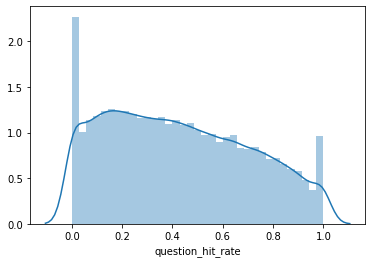

In [45]:
sns.distplot(question_feats.question_hit_rate)

In [46]:
print('Априорная вероятность верного ответа в целом по всем вопросам и турнирам', question_feats.question_hit_rate.mean() )

Априорная вероятность верного ответа в целом по всем вопросам и турнирам 0.42538653362362816


In [47]:
%%time
X = pd.merge(question_feats, X, on=['game_id','question_id'], how='left')

CPU times: user 10.6 s, sys: 6.04 s, total: 16.7 s
Wall time: 16.8 s


In [48]:
X.shape

(20911025, 38)

In [49]:
X.head(3)

,game_id,question_id,question_hit_rate,date_start,team_id,player_id,team_position,type,y,game_id_y_count,team_position_max,team_position_min,team_position_mean,team_position_std,relative_team_position_max,relative_team_position_min,relative_team_position_mean,relative_team_position_std,questions_hit_rate_min,questions_hit_rate_max,questions_hit_rate_mean,questions_hit_rate_std,questions_N_rate_min,questions_N_rate_max,questions_N_rate_mean,questions_N_rate_std,tmask_p1_hit_rate_min,tmask_p1_hit_rate_max,tmask_p1_hit_rate_mean,tmask_p1_hit_rate_std,tmask_p2_hit_rate_min,tmask_p2_hit_rate_max,tmask_p2_hit_rate_mean,tmask_p2_hit_rate_std,tmask_p3_hit_rate_min,tmask_p3_hit_rate_max,tmask_p3_hit_rate_mean,tmask_p3_hit_rate_std
0,4772,0,0.892295,2019-01-05,45556,6212,1.0,1,1,1.0,2.0,2.0,2.0,NaN,0.026316,0.026316,0.026316,NaN,0.555556,0.555556,0.555556,NaN,0.0,0.0,0.0,NaN,0.666667,0.666667,0.666667,NaN,0.5,0.5,0.5,NaN,0.5,0.5,0.5,NaN
1,4772,0,0.892295,2019-01-05,45556,15456,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4772,0,0.892295,2019-01-05,45556,18036,1.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### fit model

In [50]:
drops = ['player_id', 'y', 'game_id', 'date_start', 'team_id' ,'player_id', 'team_position', 'question_id']
use_cols = [c for c in X.columns if c not in drops]
all_features = list(X.head()[use_cols].columns)

In [51]:
X.sample(5)

,game_id,question_id,question_hit_rate,date_start,team_id,player_id,team_position,type,y,game_id_y_count,team_position_max,team_position_min,team_position_mean,team_position_std,relative_team_position_max,relative_team_position_min,relative_team_position_mean,relative_team_position_std,questions_hit_rate_min,questions_hit_rate_max,questions_hit_rate_mean,questions_hit_rate_std,questions_N_rate_min,questions_N_rate_max,questions_N_rate_mean,questions_N_rate_std,tmask_p1_hit_rate_min,tmask_p1_hit_rate_max,tmask_p1_hit_rate_mean,tmask_p1_hit_rate_std,tmask_p2_hit_rate_min,tmask_p2_hit_rate_max,tmask_p2_hit_rate_mean,tmask_p2_hit_rate_std,tmask_p3_hit_rate_min,tmask_p3_hit_rate_max,tmask_p3_hit_rate_mean,tmask_p3_hit_rate_std
8515508,5651,22,0.237945,2019-08-30,48762,126333,85.5,1,0,76.0,618.0,2.0,71.105263,89.808660,0.850144,0.015464,0.309855,0.189053,0.250000,0.888889,0.518692,0.120762,0.0,0.307692,0.009832,0.050679,0.181818,1.000000,0.545920,0.152823,0.166667,0.846154,0.509509,0.175476,0.083333,0.916667,0.500355,0.182706
11633151,5760,48,0.540218,2019-10-17,60628,183367,714.0,3,0,1.0,544.0,544.0,544.000000,NaN,0.270781,0.270781,0.270781,NaN,0.353488,0.353488,0.353488,NaN,0.0,0.000000,0.000000,NaN,0.338028,0.338028,0.338028,NaN,0.291667,0.291667,0.291667,NaN,0.430556,0.430556,0.430556,NaN
16309433,5936,11,0.731762,2019-10-04,67077,203598,138.0,2,1,3.0,170.0,47.5,97.000000,64.542622,0.481586,0.060203,0.249417,0.213951,0.388889,0.476852,0.427469,0.044965,0.0,0.142857,0.047619,0.082479,0.333333,0.583333,0.444444,0.127294,0.250000,0.500000,0.388889,0.127294,0.333333,0.541667,0.458333,0.110240
20361007,6255,94,0.361753,2019-09-20,59529,151863,279.5,3,0,4.0,254.5,51.5,119.750000,92.510810,0.856902,0.095903,0.437792,0.323035,0.177778,0.694444,0.393079,0.225178,0.0,0.000000,0.000000,0.000000,0.200000,0.583333,0.371676,0.163033,0.066667,0.750000,0.394444,0.285125,0.211111,0.750000,0.406944,0.242050
7336678,5569,8,0.128295,2019-04-05,55606,126604,62.0,1,0,15.0,215.0,1.0,59.800000,72.800559,0.396373,0.026786,0.184666,0.114303,0.422222,0.861111,0.608561,0.113630,0.0,0.846154,0.056410,0.218476,0.416667,1.000000,0.699562,0.154097,0.266667,0.866667,0.603571,0.176041,0.333333,0.916667,0.544048,0.167767


Убираем из обучения игроков, которые ранее не сыграли ни одной игры т.к. там скорее всего получится что-то тривиальное, типа априорная вероятность правильного ответа для человека без рейтинга

In [52]:
print(X.shape)
X.game_id_y_count = X.game_id_y_count.fillna(0)
X = X[X.game_id_y_count != 0]
print(X.shape)

(20911025, 38)
(17346457, 38)


In [53]:
fillna_dict = {}

для фич std заполним пропуски нулем

In [54]:
std_cols = [i for i in X.columns if i.endswith('std')]

for col in std_cols:
    X[col] = X[col].fillna(0)
    fillna_dict[col] = 0

для остальных колонок заполним пропуски средним значением

In [55]:
for col in all_features:
    mean = X[col].mean()
    X[col] = X[col].fillna(mean)
    fillna_dict[col] = mean

In [56]:
%%time
X.to_hdf('./data/X_logreg.h5', key='qwerty')

CPU times: user 3.08 s, sys: 6.36 s, total: 9.44 s
Wall time: 27.2 s


In [57]:
with open('./data/fillna_dict.json', 'w') as f:
    json.dump(fillna_dict, f)

----

In [5]:
%%time
X = pd.read_hdf('./data/X_logreg.h5')

CPU times: user 8.15 s, sys: 4.21 s, total: 12.4 s
Wall time: 12.5 s


In [6]:
with open('./data/fillna_dict.json', 'r') as f:
    fillna_dict = json.load(f)

In [7]:
drops = ['player_id', 'y', 'game_id', 'date_start', 'team_id' ,'player_id', 'team_position', 'question_id']
use_cols = [c for c in X.columns if c not in drops]
all_features = list(X.head()[use_cols].columns)

In [58]:
X.head(10)[all_features]

,question_hit_rate,type,game_id_y_count,team_position_max,team_position_min,team_position_mean,team_position_std,relative_team_position_max,relative_team_position_min,relative_team_position_mean,relative_team_position_std,questions_hit_rate_min,questions_hit_rate_max,questions_hit_rate_mean,questions_hit_rate_std,questions_N_rate_min,questions_N_rate_max,questions_N_rate_mean,questions_N_rate_std,tmask_p1_hit_rate_min,tmask_p1_hit_rate_max,tmask_p1_hit_rate_mean,tmask_p1_hit_rate_std,tmask_p2_hit_rate_min,tmask_p2_hit_rate_max,tmask_p2_hit_rate_mean,tmask_p2_hit_rate_std,tmask_p3_hit_rate_min,tmask_p3_hit_rate_max,tmask_p3_hit_rate_mean,tmask_p3_hit_rate_std
0,0.892295,1,1.0,2.0,2.0,2.00,0.00000,0.026316,0.026316,0.026316,0.000000,0.555556,0.555556,0.555556,0.000000,0.0,0.0,0.0,0.0,0.666667,0.666667,0.666667,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.500000,0.000000
29,0.892295,1,1.0,1.0,1.0,1.00,0.00000,0.013158,0.013158,0.013158,0.000000,0.611111,0.611111,0.611111,0.000000,0.0,0.0,0.0,0.0,0.750000,0.750000,0.750000,0.000000,0.583333,0.583333,0.583333,0.000000,0.500000,0.500000,0.500000,0.000000
34,0.892295,1,1.0,24.0,24.0,24.00,0.00000,0.134831,0.134831,0.134831,0.000000,0.638889,0.638889,0.638889,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.666667,0.666667,0.666667,0.000000,0.833333,0.833333,0.833333,0.000000
35,0.892295,1,2.0,75.0,20.5,47.75,38.53732,0.421348,0.269737,0.345543,0.107206,0.333333,0.500000,0.416667,0.117851,0.0,0.0,0.0,0.0,0.166667,0.416667,0.291667,0.176777,0.250000,0.416667,0.333333,0.117851,0.583333,0.666667,0.625000,0.058926
37,0.892295,1,1.0,24.0,24.0,24.00,0.00000,0.134831,0.134831,0.134831,0.000000,0.638889,0.638889,0.638889,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.666667,0.666667,0.666667,0.000000,0.833333,0.833333,0.833333,0.000000
38,0.892295,1,1.0,24.0,24.0,24.00,0.00000,0.134831,0.134831,0.134831,0.000000,0.638889,0.638889,0.638889,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.666667,0.666667,0.666667,0.000000,0.833333,0.833333,0.833333,0.000000
39,0.892295,1,1.0,24.0,24.0,24.00,0.00000,0.134831,0.134831,0.134831,0.000000,0.638889,0.638889,0.638889,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.666667,0.666667,0.666667,0.000000,0.833333,0.833333,0.833333,0.000000
41,0.892295,1,1.0,5.5,5.5,5.50,0.00000,0.072368,0.072368,0.072368,0.000000,0.472222,0.472222,0.472222,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.416667,0.416667,0.416667,0.000000,0.583333,0.583333,0.583333,0.000000
42,0.892295,1,2.0,5.5,5.5,5.50,0.00000,0.072368,0.030899,0.051634,0.029323,0.472222,0.722222,0.597222,0.176777,0.0,0.0,0.0,0.0,0.416667,0.750000,0.583333,0.235702,0.416667,0.750000,0.583333,0.235702,0.583333,0.666667,0.625000,0.058926
43,0.892295,1,1.0,5.5,5.5,5.50,0.00000,0.072368,0.072368,0.072368,0.000000,0.472222,0.472222,0.472222,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.416667,0.416667,0.416667,0.000000,0.583333,0.583333,0.583333,0.000000


In [59]:
X.y.values

array([1, 1, 1, ..., 0, 0, 0])

In [60]:
print(datetime.datetime.now())

2021-04-16 23:57:39.490948


In [61]:
%%time
lr = LogisticRegression(max_iter=1000, n_jobs=1)
lr.fit(X[all_features].values, X.y.values)

CPU times: user 2h 27min 19s, sys: 14min 18s, total: 2h 41min 38s
Wall time: 2h 35min


In [62]:
list(zip(lr.coef_.tolist()[0], all_features))

[(5.240661007879158, 'question_hit_rate'),
 (0.06476280527707987, 'type'),
 (0.0010290978770671432, 'game_id_y_count'),
 (-6.587867290069657e-05, 'team_position_max'),
 (0.0008968462158393122, 'team_position_min'),
 (-0.0009790850899672277, 'team_position_mean'),
 (0.00042593807115461226, 'team_position_std'),
 (0.15980561806018764, 'relative_team_position_max'),
 (-0.5758715990329295, 'relative_team_position_min'),
 (-1.6939708922900651, 'relative_team_position_mean'),
 (0.03490467756754931, 'relative_team_position_std'),
 (-0.022270717085329253, 'questions_hit_rate_min'),
 (-0.05369105944082633, 'questions_hit_rate_max'),
 (0.28467161497980026, 'questions_hit_rate_mean'),
 (-0.040419909843831585, 'questions_hit_rate_std'),
 (-0.027226749777632172, 'questions_N_rate_min'),
 (0.06350875824537207, 'questions_N_rate_max'),
 (0.010402387432406587, 'questions_N_rate_mean'),
 (0.049731423391614106, 'questions_N_rate_std'),
 (0.026139221271922686, 'tmask_p1_hit_rate_min'),
 (0.00500740542776

### II часть, в которой я понял, что на тесте будут ровно те же игроки, что и на трейне, а значит можно переобучаться сколько душе угодно

Обучили логистическую регрессию, теперь делаем predict_proba сам на себя (на игроков из трейна) и строим рейтинг игрока как мат.ожидание набранных баллов на "среднем" турнире со "средними" по сложности вопросами

На самом деле нужен даже не целый турнир, а просто один "средний" вопрос. 

Мы будем предсказывать вероятность дать правильный ответ - это и будет рейтинг игрока.

In [622]:
def get_rating(model, features):
    """ Для обученной модели получаем DataFrame с рейтингами игроков """
    
    # фичи берем по последней игре данного игрока т.к. там информация о всех прошлых играх
    player_feats['max_date_start'] = player_feats.player_id.map(player_feats.groupby('player_id').date_start.max())
    XX = player_feats[player_feats.date_start == player_feats.max_date_start]
    # вместо фич по вопросам подставляем "средние" значения
    XX['question_hit_rate'] = 0.4253
    # тип соревнования 
    XX['type'] = 2   
    # заполняем пропуски теми же средними, что были на этапе обучения модели
    for col in features:
        if col not in fillna_dict:
            continue
        fill_value = fillna_dict[col]           
        XX[col] = XX[col].fillna(fill_value)

    rating = XX[['player_id']]
    rating['rating'] = model.predict_proba(XX[features])[:, 1]
    
    return rating

In [605]:
rating = get_rating(model=lr, features=all_features)

In [69]:
rating['player'] = rating.player_id.map( {k: v.get('name', '') + ' ' + v.get('surname', '') 
                                          for k,v in players.items()} )

In [70]:
rating = rating.sort_values('rating', ascending=False).reset_index(drop=True)

In [88]:
!mkdir -p output
rating.to_csv('./output/rating.csv', index=False)

In [71]:
rating.head(20)

,player_id,rating,player
0,28751,0.729801,Иван Семушин
1,30152,0.725588,Артём Сорожкин
2,4270,0.724764,Александра Брутер
3,33032,0.722046,Татьяна Фёдорова
4,30270,0.719878,Сергей Спешков
5,27822,0.719542,Михаил Савченков
6,7008,0.719095,Алексей Гилёв
7,18332,0.718219,Александр Либер
8,110920,0.715694,Алексей Дворянчиков
9,27499,0.715305,Наталия Рыжанова


In [72]:
# топ 100 по версии https://rating.chgk.info/players.php на начало апреля 2021
top100_real = ['Артём Сорожкин','Михаил Савченков','Иван Семушин','Сергей Спешков','Максим Руссо',
               'Александра Брутер','Александр Либер','Михаил Левандовский','Ким Галачян','Сергей Николенко','Тимур Кафиатуллин',
               'Юрий Выменец','Антон Чернин','Наиль Фарукшин','Сергей Коновалов','Андрей Островский','Игорь Тюнькин',
               'Татьяна Фёдорова','Екатерина Лобкова','Андрей Волыхов','Кирилл Чернышёв','Дмитрий Ожигов',
               'Наталья Кудряшова','Дмитрий Петров','Руслан Хаиткулов','Елизавета Овдеенко','Дмитрий Карякин',
               'Сергей Терентьев','Егор Дружинин','Алексей Гилёв','Максим Поташев','Дмитрий Великов',
               'Вадим Яковлев','Евгений Коватенков','Николай Некрылов','Инна Семёнова','Александр Салита',
               'Станислав Мереминский','Серафим Шибанов','Михаил Малкин','Алексей Дворянчиков','Ольга Сарницкая',
               'Владимир Степанов','Александр Карчевский','Екатерина Новикова','Ринат Сибаев','Сергей Иванченко',
               'Наталия Рыжанова','Александр Мартынов','Михаил Новосёлов','Александр Марков',
               'Иван Ефремов','Рузель Халиуллин','Алексей Шередега','Эльдар Эльман','Никита Поверинов',
               'Ася Самойлова','Мария Подрядчикова','Александр Печеный','Юлия Архангельская','Глеб Николаев',
               'Александр Фингеров','Владислав Декалов','Павел Ершов','Ирина Прокофьева','Андрей Белов',
               'Анвар Мухаметкалиев','Иделия Айзятулова','Дмитрий Тарарыков','Наталья Комар','Вячеслав Колосов',
               'Юлия Дидбаридзе','Владислав Харитонов','Игорь Мокин','Евгений Перпер','Леонид Михлин',
               'Николай Крапиль','Тимур Боков','Владимир Сушков','Николай Порцель','Ирина Проскурина',
               'Карина Файзуллина','Анастасия Шестакова','Дмитрий Литвинов','Игорь Биткин','Андрей Цепаев',
               'Екатерина Шевцова','Станислав Мальчёнков','Егор Кузьменко','Вадим Раскумандрин','Эльмира Гулуева',
               'Валерия Кудрявцева','Сергей Евсеев','Алексей Чебыкин','Антон Бочкарёв','Денис Галиакберов',
               'Мария Кленницкая','Анастасия Рубашкина','Алексей Шуб','Антон Пинчук', 
              ]

top100_real_enumerated = {j:i for i,j in enumerate(top100_real, start=1)}

In [81]:
top100 = rating.head(100)

In [82]:
top100['is_in_real_top100'] = top100.player.isin(top100_real).astype(int)
top100['real_rating'] = top100.player.map(top100_real_enumerated)

In [83]:
top100.head(20)

,player_id,rating,player,is_in_real_top100,real_rating
0,28751,0.729801,Иван Семушин,1,3.0
1,30152,0.725588,Артём Сорожкин,1,1.0
2,4270,0.724764,Александра Брутер,1,6.0
3,33032,0.722046,Татьяна Фёдорова,1,18.0
4,30270,0.719878,Сергей Спешков,1,4.0
5,27822,0.719542,Михаил Савченков,1,2.0
6,7008,0.719095,Алексей Гилёв,1,30.0
7,18332,0.718219,Александр Либер,1,7.0
8,110920,0.715694,Алексей Дворянчиков,1,41.0
9,27499,0.715305,Наталия Рыжанова,1,48.0


In [84]:
top100.is_in_real_top100.sum()

59

### 59 игроков из топ-100 официального рейтинга ЧГК попали в топ-100 по модели.

----

### III часть, где предсказываются результаты турниров 2020 года с известными составами, но неизвестными вопросами

_Качество рейтинг-системы оценивается качеством предсказаний результатов турниров_

_Поэтому предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;_

Мат.ожадание набранных командой баллов - это просто сумма вероятностей ответить на вопросы. 

Но так как заранее мы не знаем сложность вопросов, можно просто оценить вероятность ответить на один "средний" вопрос. 

Рейтинг команды считаем как вероятность, что команда ответит на этот "средний" вопрос. Она равняется тому, что хотя бы один член команды ответит правильно. (сделаем упрощающее предположение, что если хотя бы один член команды дает верный ответ, то и вся команда дает верный ответ)

$$P_{team}(y=1)= 1 - \prod	P_i(y=0)$$

где P_i(y=0) - индивидуальная вероятность, что i-ый член команды не дал правильного ответа на вопрос

In [ ]:
rating = pd.read_csv('./output/rating.csv')

In [75]:
rating.shape

(36706, 3)

In [866]:
rating.head(3)

,player_id,rating,player
0,28751,0.729801,Иван Семушин
1,30152,0.725588,Артём Сорожкин
2,4270,0.724764,Александра Брутер


In [867]:
# Для скорости заведем словарь, чтобы за O(1) получать рейтинг игрока
rating_dict = rating[['player_id', 'rating']].set_index('player_id').T.to_dict('records')[0]

In [868]:
# {28751: 0.729801,
#  30152: 0.725587,
#  4270: 0.724764,
#  ... }

In [59]:
def print_metrics(rating_dict):

    known_players = set(rating_dict.keys())
    broken_games = [5670, 5714, 5816, 5922, 6243, 6309, 6316, 6336, 6348, 6350,
                    6363, 6364, 6365, 6392, 6400, 6415, 6453, 6469, 6470, 6471]
    broken_games += [6268,6294,6362,6056] 
    broken_games += [6149]

    rows = []
    for game_id in results:

        if tournaments[game_id]['dateStart'][:4] not in ['2020']:
            continue

        if game_id in broken_games:
            continue

        for team in results[game_id]:
            team_name = team['team']['name']
            position = team['position']
            team_id = team['team']['id']
            player_ids = sorted([p['player']['id'] for p in team['teamMembers']])

            product = 1
            for player_id in player_ids:
                if player_id in known_players:
                    product *= (1 - rating_dict[player_id])   
            team_rating = 1 - product            

            rows.append((game_id, team_name, position, team_id, player_ids, team_rating))
    
    df = pd.DataFrame(rows)
    df.columns = ['game_id', 'team_name', 'position', 'team_id', 'player_ids', 'team_rating']
    df.head(3)
    
    groud_truth_list = df.groupby('game_id').position.apply(list)
    model_rating_list = df.groupby('game_id').team_rating.apply(list)

    spearman_corr = []
    kendall_corr = []

    for actual, model in zip(groud_truth_list, model_rating_list):
        predicted_position = np.argsort(-np.array(model)) 

        spearman = sts.spearmanr(actual, predicted_position).correlation
        kendall = sts.kendalltau(actual, predicted_position).correlation

        spearman_corr.append(spearman)
        kendall_corr.append(kendall)

    spearman_score = np.mean(spearman_corr)
    kendall_score = np.mean(kendall_corr)
    print(f'spearman: \t {spearman_score:.6f} \nkendall: \t {kendall_score:.6f}')

In [870]:
print_metrics(rating_dict)

spearman: 	 0.715961 
kendall: 	 0.559779


----

### IV часть, где вводится ЕМ-алгоритм для учета влияния скрытой переменной "сила команды"


_Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:_

_предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;_


- Е-шаг: по вероятностям (рейтингам) игроков считаем рейтинг команды - вероятность команды верно ответить на вопрос = 1 - П P(y = 0)
- М-шаг: с помощью вероятности команды пересчитываем вероятность игрока (то есть теперь уже при условии команды)

$$P(player|team) = \frac {P(player,team)}{P(team)} = \frac{P(player) * P(team|player)} {P(team)} = \frac{P(player)*1}{P(team)} $$

In [109]:
%%time
X = pd.read_hdf('./data/X_logreg.h5')

CPU times: user 8.46 s, sys: 4.82 s, total: 13.3 s
Wall time: 13.5 s


In [110]:
X.head()

,game_id,question_id,question_hit_rate,date_start,team_id,player_id,team_position,type,y,game_id_y_count,team_position_max,team_position_min,team_position_mean,team_position_std,relative_team_position_max,relative_team_position_min,relative_team_position_mean,relative_team_position_std,questions_hit_rate_min,questions_hit_rate_max,questions_hit_rate_mean,questions_hit_rate_std,questions_N_rate_min,questions_N_rate_max,questions_N_rate_mean,questions_N_rate_std,tmask_p1_hit_rate_min,tmask_p1_hit_rate_max,tmask_p1_hit_rate_mean,tmask_p1_hit_rate_std,tmask_p2_hit_rate_min,tmask_p2_hit_rate_max,tmask_p2_hit_rate_mean,tmask_p2_hit_rate_std,tmask_p3_hit_rate_min,tmask_p3_hit_rate_max,tmask_p3_hit_rate_mean,tmask_p3_hit_rate_std
0,4772,0,0.892295,2019-01-05,45556,6212,1.0,1,1,1.0,2.0,2.0,2.00,0.00000,0.026316,0.026316,0.026316,0.000000,0.555556,0.555556,0.555556,0.000000,0.0,0.0,0.0,0.0,0.666667,0.666667,0.666667,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000,0.500000,0.500000,0.000000
29,4772,0,0.892295,2019-01-05,47075,38458,5.5,1,1,1.0,1.0,1.0,1.00,0.00000,0.013158,0.013158,0.013158,0.000000,0.611111,0.611111,0.611111,0.000000,0.0,0.0,0.0,0.0,0.750000,0.750000,0.750000,0.000000,0.583333,0.583333,0.583333,0.000000,0.500000,0.500000,0.500000,0.000000
34,4772,0,0.892295,2019-01-05,53185,489,5.5,1,1,1.0,24.0,24.0,24.00,0.00000,0.134831,0.134831,0.134831,0.000000,0.638889,0.638889,0.638889,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.666667,0.666667,0.666667,0.000000,0.833333,0.833333,0.833333,0.000000
35,4772,0,0.892295,2019-01-05,53185,1370,5.5,1,1,2.0,75.0,20.5,47.75,38.53732,0.421348,0.269737,0.345543,0.107206,0.333333,0.500000,0.416667,0.117851,0.0,0.0,0.0,0.0,0.166667,0.416667,0.291667,0.176777,0.250000,0.416667,0.333333,0.117851,0.583333,0.666667,0.625000,0.058926
37,4772,0,0.892295,2019-01-05,53185,116327,5.5,1,1,1.0,24.0,24.0,24.00,0.00000,0.134831,0.134831,0.134831,0.000000,0.638889,0.638889,0.638889,0.000000,0.0,0.0,0.0,0.0,0.416667,0.416667,0.416667,0.000000,0.666667,0.666667,0.666667,0.000000,0.833333,0.833333,0.833333,0.000000


In [111]:
X = X.rename(columns={'game_id_count': 'game_id_y_count'
                 ,'player_succes_rate': 'questions_hit_rate_mean'
                 ,'question_succes_rate': 'question_hit_rate'})

Для скорости оставим только небольшое количество признаков

In [112]:
selected_features = ['question_hit_rate',           # сложность вопроса (доля верных ответов на этот вопрос в этой игре)
                     'game_id_y_count',             # сколько игр сыграл 
#                      'relative_team_position_mean', # относительная позиция в рейтинге
                     'questions_hit_rate_mean']     # процент верных ответов данного игрока в прошлом

selected_features

['question_hit_rate', 'game_id_y_count', 'questions_hit_rate_mean']

In [113]:
def get_rating_new(model, features):
    """ Для обученной модели получаем DataFrame с рейтингами игроков """
    
    # сортируем и берем последний турнир для каждого игрока - там самая полная информация о прошлых играх
    XX = X.sort_values('game_id') \
                 .groupby('player_id') \
                 .agg( 
        {'question_hit_rate': ['last'],
         'game_id_y_count': ['last'],
#          'relative_team_position_mean': ['last'],
         'questions_hit_rate_mean': ['last'],
        }
    )
    XX.columns = features
    XX = XX.reset_index()
    
    # сложность вопроса можно заполнить сложностью "среднего" вопроса
    XX['question_hit_rate'] = 0.43417408
    
    rating = XX[['player_id']]
    try:
        rating['rating'] = model.predict_proba(XX[features])[:, 1]
    except:
        rating['rating'] = SoftlabelLogisticRegression.sigmoid(model.predict(XX[features]))

    return rating



In [114]:
class SoftlabelLogisticRegression():
    """ Лог.регрессия которая обучается на soft метки - не 0/1, а вероятность
    
    https://stackoverflow.com/questions/42800769/scikit-learn-classification-on-soft-labels/60969923#60969923
    """
    def __init__(self):
        self.model = LinearRegression()
    
    def fit(self, X, y):
        y = np.clip(y, 1e-8, 1 - 1e-8)
        inv_sig_y = np.log(y / (1 - y))
        self.model.fit(X, inv_sig_y)
        return self

    @staticmethod
    def sigmoid(x):
        ex = np.exp(x)
        return ex / (1 + ex)

    def predict(self, X):
        return self.sigmoid(self.model.predict(X))

In [115]:
model = SoftlabelLogisticRegression()

In [116]:
rating = pd.read_csv('./output/rating.csv')

X = pd.merge(X, rating[['player_id', 'rating']])

In [117]:
X[selected_features].head(4)

,question_hit_rate,game_id_y_count,questions_hit_rate_mean
0,0.892295,1.0,0.555556
1,0.776305,1.0,0.555556
2,0.463132,1.0,0.555556
3,0.541839,1.0,0.555556


In [ ]:
%%time
for i in range(3):

    # E шаг (на первом прохде берется rating из baseline модели, далее обновляется)
    X['rating_neg'] = 1 - X['rating']
    team_rating = X.groupby(['game_id', 'team_id', 'question_id']).rating_neg.prod().reset_index()
    team_rating.columns = ['game_id','team_id','question_id','team_rating']
    team_rating['team_rating'] = 1 - team_rating['team_rating']    
    X = X.drop(columns={'team_rating'}, errors='ignore')
    X = pd.merge(X, team_rating, on=['game_id', 'team_id', 'question_id'] , how='left')
    new_y = (X['rating'] / X['team_rating']).values

    # M шаг
    lr = model.fit(X[selected_features], new_y)
    X['rating'] = model.predict(X[selected_features])
    
    # метрики
    rating = get_rating_new(lr, selected_features)
    rating_dict = rating[['player_id', 'rating']].set_index('player_id').T.to_dict('records')[0]
    print_metrics(rating_dict)
    print()


Все очень жестко расходится...

----

### V часть, с рейтинг-листом турниров по сложности вопросов.